In [1]:
import sys
import os
BASE_PATH = '../../dynaphos-core/'

sys.path.append(BASE_PATH)
import dynaphos
from dynaphos import utils

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import pandas as pd
import seaborn as sns

# Load Data
params = utils.load_params(os.path.join(BASE_PATH,'config/params.yaml'))
data = pd.read_csv('results/brightness_estimate.csv')
y_pred, activation, stim_amplitudes = data['brightness_estimate'], data['tissue_activation_estimate'], data['amplitude']
results = pd.read_csv('results/brightness_and_activation_curves.csv')
parameter_estimates =  pd.read_csv('results/parameter_estimates.csv', index_col=0, squeeze=True)



# Load colorstyles 
plt.style.use('../_figurestyle/small.mplstyle')
COLORSTYLE = utils.load_params('../_figurestyle/colors.yaml')
cmap = mpl.cm.YlOrBr
norm = mpl.colors.Normalize(vmin=0, vmax=stim_amplitudes.max())
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

DOT_COLOR = COLORSTYLE['turquoise'][1]
LINE_COLOR = COLORSTYLE['red'][1]

/tmp/ipykernel_2959460/2136565376.py:23: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  parameter_estimates =  pd.read_csv('results/parameter_estimates.csv', index_col=0, squeeze=True)


In [52]:
# for i, c in enumerate([*COLORSTYLE['red'],*COLORSTYLE['turquoise'], *COLORSTYLE['orange']]) :
#     plt.plot(np.linspace(i,.1*i+1,100), color=c)


colors=COLORSTYLE['orange'] + COLORSTYLE['red'][:3][::-1]
cmap = mpl.colors.LinearSegmentedColormap.from_list("mycmap", list(zip(np.linspace(0,1,len(colors)), colors)))
cmap = mpl.colormaps.get_cmap('YlOrBr')
    
    

/tmp/ipykernel_2959460/809782340.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb1.ax.set(title = 'Stim. Amplitude',
/tmp/ipykernel_2959460/809782340.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


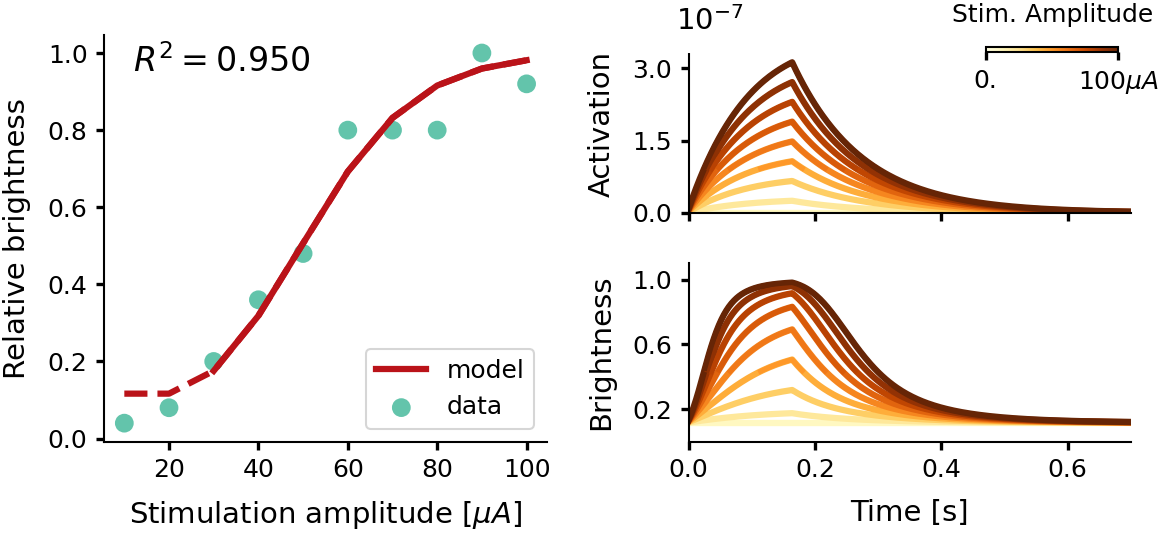

In [53]:
fig = plt.figure(figsize=(4, 2))
grid = plt.GridSpec(2, 2, width_ratios=[0.5,0.5]) #, hspace=0.2, wspace=0.2)


ax0 = fig.add_subplot(grid[0,1]) # left upper panel 
ax1 = fig.add_subplot(grid[1,1], sharex=ax0) # left lower panel
ax2 = fig.add_subplot(grid[:,0]) # right panel
cax = inset_axes(ax0, width="30%", height="3%", loc='upper right') # Colorbar


# Plot dashed lines for all activations and brightnesses
sns.lineplot(data=results, x='time', y='activation', hue='stim_condition', ax=ax0,legend=False, linestyle='-', palette=cmap)#, linewidth=.8)
sns.lineplot(data=results, x='time', y='brightness',hue='stim_condition', ax=ax1,legend=False, linestyle = '-',palette=cmap)#, linewidth=.8)

    
# Plot full lines for above-threshold Activations
for condition in results.stim_condition.unique():
    amplitude = stim_amplitudes[condition]
    color = cmap(norm(amplitude))
    data_ = results.loc[results.stim_condition == condition]
    mask  = data_.activation > params['thresholding']['activation_threshold']
    ax0.plot(data_.time[mask], data_.activation[mask], color= color, linewidth=1.2)
    ax1.plot(data_.time[mask], data_.brightness[mask], color= color, linewidth=1.2)

# ax0.axhline(params['thresholding']['activation_threshold'], linestyle = ':',  color= 'k') #, linewidth=.5)
# ax1.axhline(params['thresholding']['activation_threshold'], linestyle = ':',  color= 'k') #, linewidth=.5)

ax0.set(xlim=[0,0.7],
       xlabel= '',
       ylabel='Activation',    
       ylim = [0,3.7e-7],
       yticks=[0, 1.5e-7, 3e-7])

ax1.set(ylim=[0,1.1],
        xlabel= 'Time [s]',
        ylabel='Brightness',  
        yticks=[0.2, 0.6, 1.])


plt.setp(ax0.get_xticklabels(),visible=False)
# plt.setp(ax0.yaxis.get_children()[1],text='blabla')
scale_lbl = ax0.text(-0.02, 3.8e-7, '$10^{-7}$', size=7)
scale_lbl.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))

# Colorbar
cb1 = plt.colorbar(mappable=mappable,
                   cax= cax,
                   norm=norm,
                   orientation='horizontal')

cb1.ax.set(title = 'Stim. Amplitude',
           xticklabels = ['0.', '$100 \mu A$'])
cb1.ax.title.set_fontsize('6')


### Brightness fit

IGNORE_ZERO_ACTIVATIONS = True
x = data.amplitude
y_true = data.brightness

h1, = ax2.plot(x*1e6, y_pred,linestyle='--', color=LINE_COLOR, label='model')
# if IGNORE_ZERO_ACTIVATIONS:
h2, = ax2.plot(x[activation!=0]*1e6, y_pred[activation!=0],linestyle='-',color=LINE_COLOR, label='model')
# else:

h3 = ax2.scatter(x*1e6,y_true, label= 'data',  c= [DOT_COLOR,]*10) #list(colormapping.values()) ) # ['r'])

ax2.set(xlabel='Stimulation amplitude [$\mu A$]',
       ylabel='Relative brightness')
ax2.legend(labels=['model', 'data'], handles=[h2,h3], loc='lower right')
ax2.text(12,0.95,f'$R^2 = {parameter_estimates["r-squared"]:0.3f}$',
            bbox={'color':'white','fill':True},horizontalalignment = 'left')




plt.tight_layout()


plt.show()


In [54]:
fig.savefig('results/Brightness_activation_curves_restyled.png',bbox_inches='tight')